### Import part

In [1]:
import glob
import unicodedata
import string
import codecs 
import torch
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

##  Classification Using Character-Level Recurrent Neural Networks

### Preparing Data

In [2]:
all_train_filenames = glob.glob('train/*.txt')
all_val_filenames = glob.glob('val/*.txt')
print(all_train_filenames)
print(all_val_filenames)

['train/in.txt', 'train/pk.txt', 'train/fr.txt', 'train/af.txt', 'train/cn.txt', 'train/za.txt', 'train/fi.txt', 'train/ir.txt', 'train/de.txt']
['val/in.txt', 'val/pk.txt', 'val/fr.txt', 'val/af.txt', 'val/cn.txt', 'val/za.txt', 'val/fi.txt', 'val/ir.txt', 'val/de.txt']


In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines_train = {}
category_lines_val = {}
all_train_categories = []
all_val_categories = []


# Read a file and split into lines
def readLines(filename):
    ascii_vocab = list()
    lines = codecs.open(filename,"r",encoding="utf-8",errors='ignore').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_train_filenames:
    print(filename)
    category = filename.split('/')[-1].split('.')[0]
    all_train_categories.append(category)
    lines = readLines(filename)
    category_lines_train[category] = lines

n_categories = len(all_train_categories)
print('n_categories =', n_categories)
for filename in all_val_filenames:
    print(filename)
    category = filename.split('/')[-1].split('.')[0]
    all_val_categories.append(category)
    lines = readLines(filename)
    category_lines_val[category] = lines
n_categories_val = len(all_val_categories)
print('n_categories_val =', n_categories_val)

train/in.txt
train/pk.txt
train/fr.txt
train/af.txt
train/cn.txt
train/za.txt
train/fi.txt
train/ir.txt
train/de.txt
n_categories = 9
val/in.txt
val/pk.txt
val/fr.txt
val/af.txt
val/cn.txt
val/za.txt
val/fi.txt
val/ir.txt
val/de.txt
n_categories_val = 9


### Names to tensors

In [5]:
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

### Creating the Network

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
#         hidden =  F.relu(self.i2h(combined))
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

### Manually testing the network

In [19]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

### Preparing for Training

In [8]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_train_categories[category_i], category_i

In [9]:
def random_training_pair(all_categories,category_lines):                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

In [10]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

In [11]:
def showloss(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.init_hidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
    return loss.item()

In [26]:
n_epochs = 100000
print_every = 5000
plot_every = 1000
criterion = nn.NLLLoss() # set up loss function
learning_rate = 0.002 # If you set this too high, it might explode. If too low, it might not learn

optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate )
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max = (n_epochs // 9) + 1)

In [13]:
len(category_lines_train)

9

In [21]:
# Keep track of losses for plotting
current_loss = 0
current_val = 0
all_losses = []
val_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
#     scheduler.step(epoch)
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair(all_train_categories,category_lines_train)
    category_val, line_val, category_tensor_val, line_tensor_val = random_training_pair(all_val_categories,category_lines_val)
    output, loss = train(category_tensor, line_tensor)
    val_loss = showloss(category_tensor_val,line_tensor_val)
    current_loss += loss
    current_val += val_loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        val_losses.append(current_val / plot_every)
        current_loss = 0
        current_val = 0

/Users/weihaoran/env/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 6% (0m 18s) 2.3200 bllal colony / af ✗ (pk)
10000 12% (0m 35s) 2.1654 munhunga nzamba de cima / fi ✗ (za)
15000 18% (0m 51s) 1.1817 fontainesluyeres / fr ✓
20000 25% (1m 7s) 1.3744 lafangkeng / cn ✓
25000 31% (1m 25s) 1.7313 tianjing xiang / cn ✗ (in)
30000 37% (1m 40s) 2.1098 ikaalinen / fr ✗ (fi)
35000 43% (1m 55s) 1.9392 finndaro / de ✗ (fi)
40000 50% (2m 13s) 1.4605 chaghatar / af ✗ (ir)
45000 56% (2m 31s) 3.8140 chak one hundred sixtyeightone hundred seventyone nb / in ✗ (pk)
50000 62% (2m 48s) 0.3309 dinbhuwala / pk ✓
55000 68% (3m 3s) 1.4735 khwaja gauhar / pk ✗ (af)
60000 75% (3m 17s) 1.8888 taza shahr / pk ✗ (za)
65000 81% (3m 34s) 0.9403 bemafaika ambony / af ✓
70000 87% (3m 50s) 2.1095 dainadubi / cn ✗ (in)
75000 93% (4m 6s) 1.2574 konar / ir ✓
80000 100% (4m 21s) 3.2181 tatienwa / fi ✗ (cn)


### Result Plotting

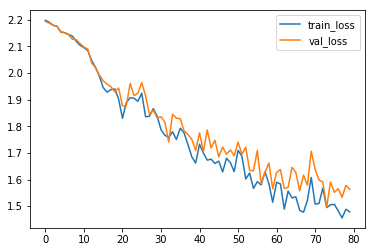

In [22]:
plt.figure()
plt.plot(all_losses, label= "train_loss")
plt.plot(val_losses, label= "val_loss")
plt.legend(loc='upper right')

### Evaluating the result

/Users/weihaoran/env/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


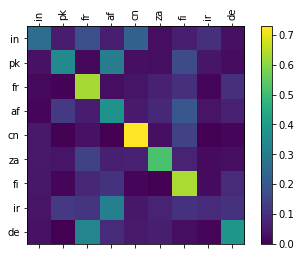

macro Accuracy: 0.440608
micro Accuracy: 0.442300


In [23]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair(all_val_categories,category_lines_val)
#     category, line, category_tensor, line_tensor = random_training_pair(all_train_categories,category_lines_train)
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_val_categories.index(category)
#     category_i = all_train_categories.index(category)
    confusion[category_i][guess_i] += 1
micro_confusion = confusion.clone()
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
# Set up axes
ax.set_xticklabels([''] + all_val_categories, rotation=90)
# ax.set_xticklabels([''] + all_train_categories, rotation=90)
ax.set_yticklabels([''] + all_val_categories)
# ax.set_yticklabels([''] + all_train_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
acc = 0
for i in range(confusion.shape[0]):
    acc+= confusion[i][i]
macro_acc = acc/confusion.shape[0]
print("macro Accuracy: %f"%macro_acc)
acc = 0
for i in range(micro_confusion.shape[0]):
    acc+= micro_confusion[i][i]
micro_acc = acc/n_confusion
print("micro Accuracy: %f"%micro_acc)


### Changing learning rate

In [31]:
learning_rates = [0.002, 0.001, 0.0006, 0.0004, 0.0002]
train_losses = [[], [], [], [], []]
val_losses = [[], [], [], [], [], []]
for i in range(len(learning_rates)):
    rnn_lr = RNN(n_letters, n_hidden, n_categories)
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rates[i])
    for epoch in range(1, n_epochs + 1):
        #     scheduler.step(epoch)
        # Get a random training input and target
        category, line, category_tensor, line_tensor = random_training_pair(
            all_train_categories, category_lines_train)
        category_val, line_val, category_tensor_val, line_tensor_val = random_training_pair(
            all_val_categories, category_lines_val)
        output, loss = train(category_tensor, line_tensor)
        val_loss = showloss(category_tensor_val, line_tensor_val)
        current_loss += loss
        current_val += val_loss

        # Print epoch number, loss, name and guess
        if epoch % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch /
                                                    n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
        if epoch % plot_every == 0:
            train_losses[i].append(current_loss / plot_every)
            val_losses[i].append(current_val / plot_every)
            current_loss = 0
            current_val = 0

/Users/weihaoran/env/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (239m 58s) 0.8627 kanglong / cn ✓
10000 10% (240m 14s) 3.7439 liren / fr ✗ (cn)
15000 15% (240m 28s) 1.5443 sarinku / fi ✗ (ir)
20000 20% (240m 42s) 1.3039 buninagara / in ✓
25000 25% (240m 56s) 1.2818 goth mir muhammad baloch / de ✗ (pk)
30000 30% (241m 9s) 0.2251 azaryevka / za ✓
35000 35% (241m 23s) 0.7935 goth malkani / pk ✓
40000 40% (241m 37s) 0.0522 myza liyepa / za ✓
45000 45% (241m 51s) 1.6539 gardanehye robat sefid / af ✗ (fi)
50000 50% (242m 6s) 1.2110 mina quinto del hierro / de ✗ (in)
55000 55% (242m 21s) 0.4457 vraignesleshornoy / fr ✓
60000 60% (242m 36s) 0.6014 glina / in ✓
65000 65% (242m 53s) 0.2226 xingzhuang / cn ✓
70000 70% (243m 10s) 3.9314 mad ahmad khan pitafi / fi ✗ (pk)
75000 75% (243m 25s) 1.4283 ruzhin / cn ✗ (in)
80000 80% (243m 41s) 0.3798 kierikkala / fi ✓
85000 85% (243m 57s) 0.2735 xiaoju / cn ✓
90000 90% (244m 14s) 5.0553 shafi muhammad jepar / pk ✗ (fi)
95000 95% (244m 32s) 0.3291 fickle hill / fi ✓
100000 100% (244m 48s) 0.5437 goth yar muham

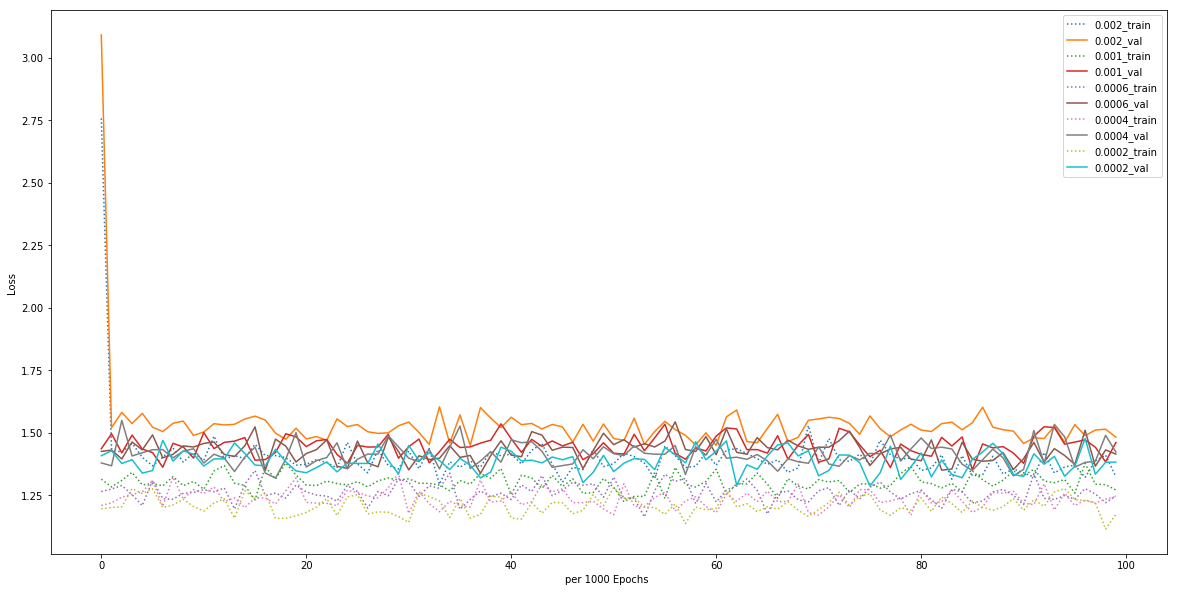

In [48]:
plt.figure(figsize=(20,10),)
for i in range(len(learning_rates)):
    line
    plt.plot(train_losses[i], label= str(learning_rates[i])+"_train",linestyle=":")
    plt.plot(val_losses[i], label= str(learning_rates[i])+"_val")
# plt.plot(train_losses[0], label= "train_loss")
# plt.plot(val_losses[0], label= "val_loss")
plt.ylabel('Loss')
plt.xlabel('per 1000 Epochs ')
plt.legend(loc='upper right')

### Network improvement

In [ ]:
# define a different RNN model
class nRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
#         hidden =  F.relu(self.i2h(combined))
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))